In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from pre_processing import *
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore")

/home/edu/miniconda3/envs/causal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('data/BatteryFeatures.csv')

In [3]:
cleaned_data = remove_outliers_chi_squared(data)

cycle_life = cleaned_data["cycle_life"]
cleaned_data = cleaned_data.drop(columns=['cycle_life'])

normalized_data = normalize_data(cleaned_data)

discretized_data = discretize_data_with_lower_bounds(normalized_data,bins = 20)

binarized_data = binarize_columns(discretized_data)

In [4]:
target_data =  binarized_data

frequent_itemsets = apriori(target_data, min_support=0.05, use_colnames=True)

In [5]:
def generate_frequent_itemsets(data, min_support=0.1):
    """
    Generate frequent itemsets using the FP-Growth algorithm.
    """
    frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    return frequent_itemsets

def evaluate_itemsets(data, target, itemsets):
    """
    Evaluate the interestingness of each itemset.
    """
    evaluations = []
    for _, row in itemsets.iterrows():
        columns = row['itemsets']
        mask = np.ones(len(data), dtype=bool)
        for col in columns:
            mask &= (data[col] == 1)
        mask = mask.values
        subgroup_data = target[mask]
        if len(subgroup_data) > 0:
            score = subgroup_data.mean()  # Use mean target value as score
            evaluations.append((columns, score))
    return evaluations

def select_best_itemsets(evaluations, top_n=5):
    
    """
    Select the top N most interesting itemsets.
    """
    
    evaluations.sort(key=lambda x: x[1], reverse=True)
    return evaluations[:top_n]

def sd_map(X, Y, min_support=0.1, top_n=5, max_iterations=10):
    
    """
    SD-Map algorithm implementation for binary attributes using Apriori.
    Input:
        X     - Dataset (pandas DataFrame) with binary attributes
        Y     - Target variable (pandas Series)
        min_support - Minimum support for the FP-Growth algorithm
        top_n - Number of top itemsets to select
        max_iterations - Maximum number of iterations
    Output:
        discovered_subgroups - List of discovered subgroups
    """
    
    discovered_subgroups = []
    for _ in range(max_iterations):
        itemsets = generate_frequent_itemsets(X, min_support=min_support)
        if itemsets.empty:
            break
        evaluations = evaluate_itemsets(X, Y, itemsets)
        best_itemsets = select_best_itemsets(evaluations, top_n)
        if not best_itemsets:
            break
        discovered_subgroups.extend(best_itemsets)
        for columns, _ in best_itemsets:
            mask = np.ones(len(X), dtype=bool)
            for col in columns:
                mask &= (X[col] == 1)
            mask = mask.values
            X = X[~mask].reset_index(drop=True)
            Y = Y[~mask].reset_index(drop=True)
    return discovered_subgroups

binarized_data = binarized_data.astype(bool)
subgroups = sd_map(binarized_data, cycle_life, min_support=0.05, top_n=5, max_iterations=10)

In [6]:
def create_subgroup_dataset(X, discovered_subgroups):
    """
    Create a new dataset where each attribute indicates membership in a subgroup.
    """
    new_data = pd.DataFrame(index=X.index)
    
    for i, (subgroup, _) in enumerate(discovered_subgroups):
        new_col = np.ones(len(X), dtype=bool)
        for attr in subgroup:
            new_col &= (X[attr] == 1)
        new_data[f'Subgroup_{i}'] = new_col.astype(int)
    
    return new_data

In [7]:
new_X = create_subgroup_dataset(binarized_data, subgroups)
cut_importance = 4.4858398383517235

In [8]:
X = new_X
Y = cycle_life

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict using the model
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the feature importances
print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 28609.4700627211
R^2 Score: 0.45894946552462246
Feature Importances: [2.8210929e-01 7.4250125e-03 0.0000000e+00 2.4320369e-03 2.5147659e-04
 1.7418056e-03 0.0000000e+00 2.9031333e-01 2.7769157e-03 0.0000000e+00
 2.3521387e-04 9.4934337e-02 1.3552260e-03 2.9481519e-03 0.0000000e+00
 9.0878422e-04 0.0000000e+00 8.4820222e-03 0.0000000e+00 4.4559482e-03
 2.5251124e-03 9.3057868e-04 0.0000000e+00 0.0000000e+00 4.9748637e-02
 1.7415595e-01 1.3659233e-02 5.0030039e-03 1.1015129e-02 0.0000000e+00
 7.5168749e-03 4.5675160e-03 6.9922395e-03 1.2883535e-04 1.5619172e-03
 4.0726759e-03 7.3056924e-03 1.4731585e-04 0.0000000e+00 5.3812121e-04
 6.3583069e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.1584474e-04 7.9756109e-03 2.9468304e-04 1.3965560e-04 0.0000000e+00]


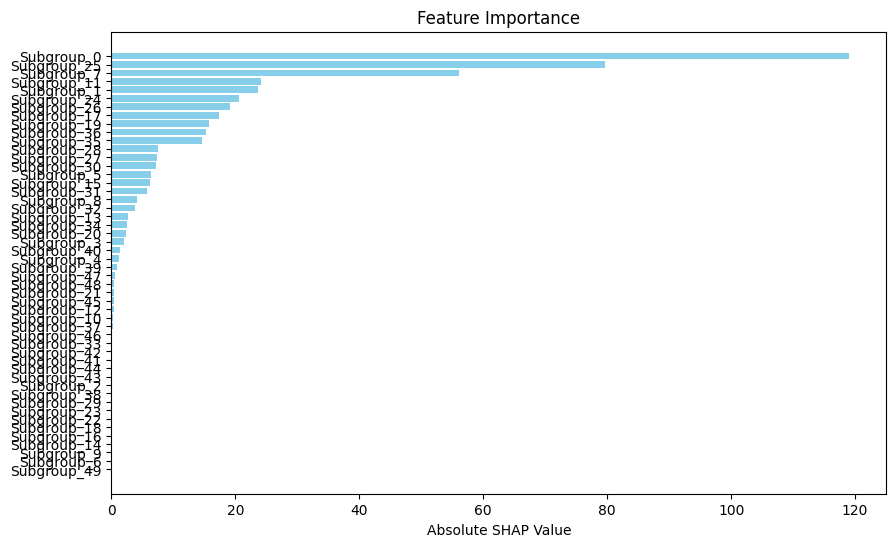

Feature Importance:
        Feature  Importance
0    Subgroup_0  119.089354
25  Subgroup_25   79.664545
7    Subgroup_7   56.137604
11  Subgroup_11   24.134411
1    Subgroup_1   23.601888
24  Subgroup_24   20.638213
26  Subgroup_26   19.116986
17  Subgroup_17   17.347639
19  Subgroup_19   15.722868
36  Subgroup_36   15.351075
35  Subgroup_35   14.702450
28  Subgroup_28    7.568621
27  Subgroup_27    7.305758
30  Subgroup_30    7.281653
5    Subgroup_5    6.317465
15  Subgroup_15    6.299789
31  Subgroup_31    5.742063
8    Subgroup_8    4.203573
32  Subgroup_32    3.776897
13  Subgroup_13    2.734517
34  Subgroup_34    2.539951
20  Subgroup_20    2.407591
3    Subgroup_3    2.076868
40  Subgroup_40    1.327811
4    Subgroup_4    1.265953
39  Subgroup_39    0.840076
47  Subgroup_47    0.536492
48  Subgroup_48    0.483707
21  Subgroup_21    0.411266
45  Subgroup_45    0.406346
12  Subgroup_12    0.361487
10  Subgroup_10    0.345152
37  Subgroup_37    0.285320
46  Subgroup_46    0.164591


In [9]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": mean_abs_shap_values
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute SHAP Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

print("Feature Importance:")
print(importance_df)

In [10]:
important_features = importance_df[importance_df['Importance'] > cut_importance]
important_features

,Feature,Importance
0,Subgroup_0,119.089354
25,Subgroup_25,79.664545
7,Subgroup_7,56.137604
11,Subgroup_11,24.134411
1,Subgroup_1,23.601888
24,Subgroup_24,20.638213
26,Subgroup_26,19.116986
17,Subgroup_17,17.347639
19,Subgroup_19,15.722868
36,Subgroup_36,15.351075


In [11]:
(important_features.Importance).mean()

26.236610536680995